# Profile of `maze_dataset` Dumping and Loading

In [1]:
import os
import itertools
from typing import Callable, Any
import cProfile
import pstats
import copy
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from muutils.statcounter import StatCounter

from maze_dataset.dataset.maze_dataset import (
    MazeDataset,
    MazeDatasetConfig,
)
from maze_dataset.generation.generators import GENERATORS_MAP
from maze_dataset.utils import timeit_fancy, FancyTimeitResult

## Generate Datasets


In [2]:
cfgs: list[MazeDatasetConfig] = [
    MazeDatasetConfig(
		name="test",
		grid_n=grid_n,
		n_mazes=n_mazes,
		maze_ctor=GENERATORS_MAP['gen_dfs'],
	)
    for grid_n, n_mazes in itertools.product(
		[10],
		np.logspace(1, 3, 5, dtype=int).tolist(), # 1k
		# np.logspace(0, 4, 9, dtype=int).tolist(), # 10k
	)
]

datasets: list[MazeDataset] = [MazeDataset.from_config(cfg) for cfg in cfgs]

## Profile

In [3]:
columns: list[str] = ['grid_n', 'n_mazes', 'serialize', 'serialize_minimal', 'load', 'load_minimal', 'save', 'save_minimal', 'read', 'read_minimal']
speeds_data: list[dict] = list()


In [4]:
def wrapped_timeit_fancy(
        name: str,
        function: Callable,
        do_profiling: bool,
        repeats: int,
        timing_stat: Callable[[StatCounter], float],
    ) -> tuple[dict, Any]:
    output: dict = dict()

    result: FancyTimeitResult = timeit_fancy(
        function,
        get_return=True,
        do_profiling=do_profiling,
        repeats=repeats,
    )

    output[name] = timing_stat(result.timings)
    output[f"{name}:stats"] = result.timings
    if do_profiling:
        output[f"{name}:profiling"] = result.profile

    return output, result.return_value



def measure_dataset_speed(
        d: MazeDataset, 
        do_profiling: bool = True,
        repeats: int = 1,
        timing_stat: Callable[[StatCounter], float] = StatCounter.min,
    ) -> dict:
    if repeats > 1:
        warnings.warn("Repeats > 1, results might not be accurate due to generation metadata being collected.")
    kwargs_fancy_timeit: dict = dict(
        do_profiling=do_profiling,
        timing_stat=timing_stat,
        repeats=repeats,
    )
    d.cfg.serialize_minimal_threshold = None
    _d_cpy: MazeDataset = copy.deepcopy(d)
    # set up row data
    row_data: dict = dict(
        grid_n=d.cfg.grid_n,
        n_mazes=d.cfg.n_mazes,
    )
    # serialization & loading
    info_serialize, result_serialize = wrapped_timeit_fancy(
        'serialize', _d_cpy.serialize, **kwargs_fancy_timeit
    )
    row_data.update(info_serialize)
    _d_cpy = copy.deepcopy(d)

    info_serialize_min, result_serialize_min = wrapped_timeit_fancy(
        'serialize_minimal', _d_cpy._serialize_minimal, **kwargs_fancy_timeit
    )
    row_data.update(info_serialize_min)
    _d_cpy = copy.deepcopy(d)

    info_serialize_min_alt, result_serialize_min_alt = wrapped_timeit_fancy(
        'serialize_minimal_alt', _d_cpy._serialize_minimal_alt, **kwargs_fancy_timeit
    )
    row_data.update(info_serialize_min_alt)
    _d_cpy = copy.deepcopy(d)
    info_serialize_min_cat, result_serialize_min_cat = wrapped_timeit_fancy(
        'serialize_minimal_soln_cat', _d_cpy._serialize_minimal_soln_cat, **kwargs_fancy_timeit
    )
    row_data.update(info_serialize_min_cat)
    _d_cpy = copy.deepcopy(d)

    row_data.update(wrapped_timeit_fancy(
        'load', lambda: MazeDataset.load(result_serialize), **kwargs_fancy_timeit
    )[0])
    row_data.update(wrapped_timeit_fancy(
        'load_minimal', lambda: MazeDataset._load_minimal(result_serialize_min), **kwargs_fancy_timeit
    )[0])
    row_data.update(wrapped_timeit_fancy(
        'load_minimal_soln_cat', lambda: MazeDataset._load_minimal_soln_cat(result_serialize_min_cat), **kwargs_fancy_timeit
    )[0])
    
    # saving and loading
    path_default: str = f'../data/{d.cfg.to_fname()}.zanj'
    path_min: str = f'../data/{d.cfg.to_fname()}_min.zanj'

    # default
    d.cfg.serialize_minimal_threshold = None
    _d_cpy = copy.deepcopy(d)
    row_data.update(wrapped_timeit_fancy(
        'save', lambda: _d_cpy.save(file_path=path_default), **kwargs_fancy_timeit
    )[0])
    _d_cpy = copy.deepcopy(d)

    row_data.update(wrapped_timeit_fancy(
        'read', lambda: MazeDataset.read(file_path=path_default), **kwargs_fancy_timeit
    )[0])

    # minimal
    d.cfg.serialize_minimal_threshold = 0
    _d_cpy = copy.deepcopy(d)
    row_data.update(wrapped_timeit_fancy(
        'save_minimal', lambda: _d_cpy.save(file_path=path_min), **kwargs_fancy_timeit
    )[0])
    _d_cpy = copy.deepcopy(d)
    
    row_data.update(wrapped_timeit_fancy(
        'read_minimal', lambda: MazeDataset.read(file_path=path_min), **kwargs_fancy_timeit
    )[0])

    # asserts
    # assert d == read_default
    # assert d == read_minimal

    # reset cfg?
    d.cfg.serialize_minimal_threshold = None

    return row_data

## Profile small datasets only

In [5]:
for i, d in enumerate(datasets):
    print(f'Profiling {i+1}/{len(datasets)}:\t{d.cfg}')
    result = measure_dataset_speed(d)
    speeds_data.append(result)
    cols_short: str = str({k : v for k,v in result.items() if ':' not in k})
    print(f"\t{cols_short}")
    print(f"\t{str(d.cfg)}")

Profiling 1/5:	MazeDatasetConfig(name='test', seq_len_min=1, seq_len_max=512, seed=42, applied_filters=[], grid_n=10, n_mazes=10, maze_ctor=<function LatticeMazeGenerators.gen_dfs at 0x000002DB28E3CFE0>, maze_ctor_kwargs={}, serialize_minimal_threshold=None)
	{'grid_n': 10, 'n_mazes': 10, 'serialize': 0.0032480000518262386, 'serialize_minimal': 0.0064737999346107244, 'serialize_minimal_alt': 0.0035286000929772854, 'serialize_minimal_soln_cat': 0.004123099963180721, 'load': 0.02376980008557439, 'load_minimal': 0.005310900043696165, 'load_minimal_soln_cat': 0.00330550002399832, 'save': 0.03820930002257228, 'read': 0.03004349989350885, 'save_minimal': 0.01811849989462644, 'read_minimal': 0.009767699986696243}
	MazeDatasetConfig(name='test', seq_len_min=1, seq_len_max=512, seed=42, applied_filters=[{'name': 'collect_generation_meta', 'args': (), 'kwargs': {}}], grid_n=10, n_mazes=10, maze_ctor=<function LatticeMazeGenerators.gen_dfs at 0x000002DB28E3CFE0>, maze_ctor_kwargs={}, serialize_mi

### Results

In [6]:
SPEEDS: pd.DataFrame = pd.DataFrame(speeds_data)

SPEEDS


,grid_n,n_mazes,serialize,serialize:stats,serialize:profiling,serialize_minimal,serialize_minimal:stats,serialize_minimal:profiling,serialize_minimal_alt,serialize_minimal_alt:stats,...,save:profiling,read,read:stats,read:profiling,save_minimal,save_minimal:stats,save_minimal:profiling,read_minimal,read_minimal:stats,read_minimal:profiling
0,10,10,0.003248,{0.0032480000518262386: 1},<pstats.Stats object at 0x000002DB28F6FED0>,0.006474,{0.0064737999346107244: 1},<pstats.Stats object at 0x000002DB28FAEB50>,0.003529,{0.0035286000929772854: 1},...,<pstats.Stats object at 0x000002DB29FE04D0>,0.030043,{0.03004349989350885: 1},<pstats.Stats object at 0x000002DB2A03F3D0>,0.018118,{0.01811849989462644: 1},<pstats.Stats object at 0x000002DB2A009390>,0.009768,{0.009767699986696243: 1},<pstats.Stats object at 0x000002DB28E8BF50>
1,10,31,0.001975,{0.0019751000218093395: 1},<pstats.Stats object at 0x000002DB2A103B50>,0.007649,{0.007649300037883222: 1},<pstats.Stats object at 0x000002DB2C04E350>,0.006228,{0.0062275000382214785: 1},...,<pstats.Stats object at 0x000002DB2BBAAA90>,0.080706,{0.0807057999772951: 1},<pstats.Stats object at 0x000002DB2A399ED0>,0.020800,{0.020800499944016337: 1},<pstats.Stats object at 0x000002DB2A0041D0>,0.009555,{0.009555099997669458: 1},<pstats.Stats object at 0x000002DB2A3B19D0>
2,10,100,0.004177,{0.004176600021310151: 1},<pstats.Stats object at 0x000002DB2A3070D0>,0.019312,{0.019312400021590292: 1},<pstats.Stats object at 0x000002DB29FB7050>,0.014904,{0.014904400100931525: 1},...,<pstats.Stats object at 0x000002DB2A097B50>,0.250279,{0.25027899991255254: 1},<pstats.Stats object at 0x000002DB2AB20150>,0.024994,{0.024993699975311756: 1},<pstats.Stats object at 0x000002DB2A53E210>,0.011269,{0.011269399896264076: 1},<pstats.Stats object at 0x000002DB2C1005D0>
3,10,316,0.003952,{0.0039521000580862164: 1},<pstats.Stats object at 0x000002DB2AC23990>,0.084893,{0.08489300007931888: 1},<pstats.Stats object at 0x000002DB2A224810>,0.049292,{0.049292200012132525: 1},...,<pstats.Stats object at 0x000002DB2A097F90>,0.702151,{0.702151200035587: 1},<pstats.Stats object at 0x000002DB2A34A710>,0.039603,{0.039602800039574504: 1},<pstats.Stats object at 0x000002DB29FFD610>,0.013485,{0.013484700000844896: 1},<pstats.Stats object at 0x000002DB2A1761D0>
4,10,1000,0.008692,{0.008692299947142601: 1},<pstats.Stats object at 0x000002DB2B530B50>,0.159069,{0.15906850004103035: 1},<pstats.Stats object at 0x000002DB2B696A10>,0.132060,{0.13205960008781403: 1},...,<pstats.Stats object at 0x000002DB2A1AFA90>,2.292076,{2.2920762000139803: 1},<pstats.Stats object at 0x000002DB2A409790>,0.093033,{0.09303310001268983: 1},<pstats.Stats object at 0x000002DB2C6E4490>,0.023239,{0.023238699999637902: 1},<pstats.Stats object at 0x000002DB2B87CC10>


In [8]:


def compute_speedups(speeds: pd.DataFrame, column_measurement_prefixes: list[str] = ['serialize', 'load', 'save', 'read']) -> pd.DataFrame:
    for prefix in column_measurement_prefixes:
        speeds[f'{prefix}_speedup'] = speeds[f'{prefix}'] / speeds[f'{prefix}_minimal']
    return speeds

SPEEDS = compute_speedups(SPEEDS)

In [9]:
SPEEDS[[c for c in SPEEDS.columns if ':' not in c]]

,grid_n,n_mazes,serialize,serialize_minimal,serialize_minimal_alt,serialize_minimal_soln_cat,load,load_minimal,load_minimal_soln_cat,save,read,save_minimal,read_minimal,serialize_speedup,load_speedup,save_speedup,read_speedup
0,10,10,0.003248,0.006474,0.003529,0.004123,0.023770,0.005311,0.003306,0.038209,0.030043,0.018118,0.009768,0.501715,4.475663,2.108856,3.075801
1,10,31,0.001975,0.007649,0.006228,0.006930,0.065631,0.003748,0.003349,0.086950,0.080706,0.020800,0.009555,0.258207,17.509591,4.180212,8.446358
2,10,100,0.004177,0.019312,0.014904,0.015366,0.209486,0.003861,0.004332,0.268266,0.250279,0.024994,0.011269,0.216265,54.257007,10.733329,22.208725
3,10,316,0.003952,0.084893,0.049292,0.047136,0.699620,0.009617,0.009913,0.336922,0.702151,0.039603,0.013485,0.046554,72.745233,8.507525,52.070213
4,10,1000,0.008692,0.159069,0.132060,0.155759,2.303879,0.013101,0.016566,0.775084,2.292076,0.093033,0.023239,0.054645,175.859237,8.331269,98.631860


Plotting serialize timings and speedups
Plotting grid_n=10
Plotting load timings and speedups
Plotting grid_n=10
Plotting save timings and speedups
Plotting grid_n=10
Plotting read timings and speedups
Plotting grid_n=10


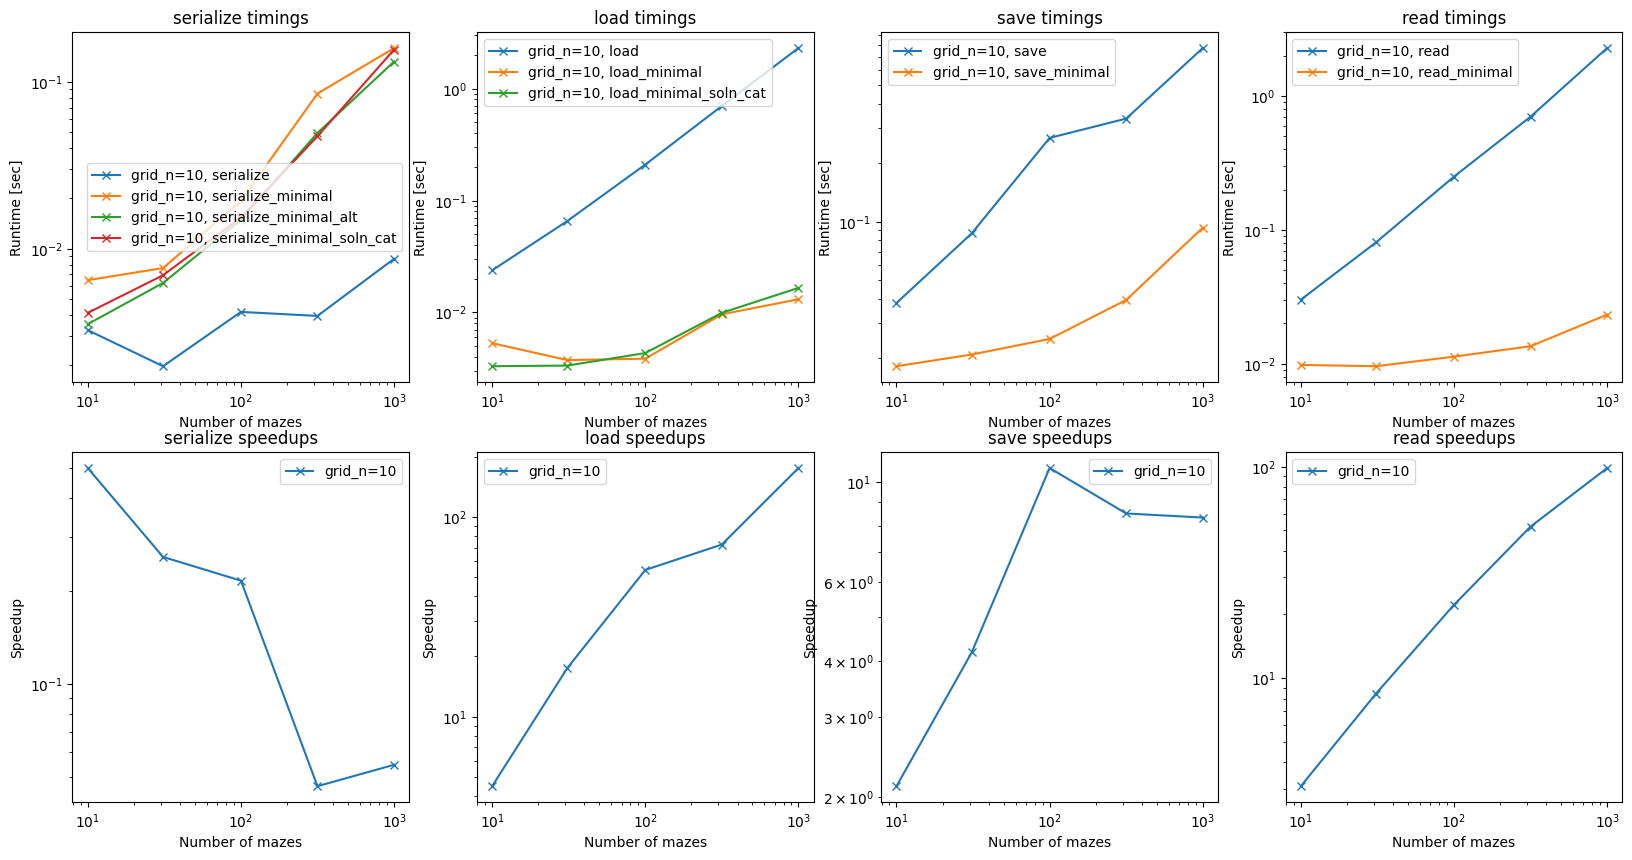

In [11]:
def plot_speeds(speeds: pd.DataFrame, column_measurement_prefixes: list[str] = ['serialize', 'load', 'save', 'read']) -> None:
    n_measurements: int = len(column_measurement_prefixes)
    fig, axs = plt.subplots(2, n_measurements, figsize=(n_measurements*5, 10))

    unique_grid_ns: list[int] = speeds['grid_n'].unique().tolist()

    for i, prefix in enumerate(column_measurement_prefixes):
        print(f'Plotting {prefix} timings and speedups')
        for grid_n in unique_grid_ns:
            print(f'Plotting grid_n={grid_n}')
            # raw timings
            ax_timings = axs[0, i]
            speeds_masked = speeds[speeds['grid_n'] == grid_n].sort_values('n_mazes')
            x_n_mazes = speeds_masked['n_mazes']

            # Plotting
            # ax_timings.plot(x_n_mazes, speeds_masked[f'{prefix}'], "x-", label=f'grid_n={grid_n}, {prefix}')
            # ax_timings.plot(x_n_mazes, speeds_masked[f'{prefix}_minimal'], "x-", label=f'grid_n={grid_n}, {prefix}_minimal')

            # _alt = f'{prefix}_minimal_alt'
            # if _alt in speeds.columns:
            #     ax_timings.plot(x_n_mazes, speeds_masked[_alt], "x-", label=f'grid_n={grid_n}, {_alt}')
            for col in speeds_masked.columns:
                if (prefix in col) and ('speedup' not in col) and (":" not in col):
                    ax_timings.plot(x_n_mazes, speeds_masked[col], "x-", label=f'grid_n={grid_n}, {col}')

            # Setting multiple properties with `set`
            ax_timings.set(xscale='log', yscale='log', xlabel='Number of mazes', ylabel='Runtime [sec]', title=f'{prefix} timings')
            ax_timings.legend()

            # speedups
            ax_speedups = axs[1, i]
            ax_speedups.plot(x_n_mazes, speeds_masked[f'{prefix}_speedup'], "x-", label=f'grid_n={grid_n}')

            # Setting multiple properties with `set` for ax_speedups
            ax_speedups.set(xscale='log', yscale='log', xlabel='Number of mazes', ylabel='Speedup', title=f'{prefix} speedups')
            ax_speedups.legend()


plot_speeds(SPEEDS)


Comparing rows 2 and 4, it appears that the `grid_n` has a relatively small effect on `serialize` and `load` runtimes. Those functions appear to run in $O(n_{\mathrm{mazes}})$ time. `grid_n` does impact `save` and `read`, but not their `_minimal` counterparts as much.

To compare the speed of analogous procedures vs `n_mazes`, the plots below show data from `speeds.loc[3:,:]`.

In [ ]:
SPEEDS[['grid_n', 'n_mazes', 'serialize_minimal_alt:profiling']]

In [ ]:
SPEEDS['serialize_minimal_alt:profiling'][8].sort_stats('cumulative').print_stats(20)